# Spectral Sensitivity

In [1]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import seaborn as sns

In [2]:
group_colors = {
    'male': '#D7301F',  # Vibrant red with an orangish hue (for males)
    'female': '#F4A40B',  # Strong yellow (for females)
    'atoke': '#654321'   # Duller brown (for atokes)
}

In [3]:
# Bring in data
spectral_df = pd.read_csv('../data/Pd_spectral_sensitivity.csv')
spectral_df['Condition'] = spectral_df[['Group', 'EyePosition']].agg('-'.join, axis=1)
spectral_df['Stage'] = np.where(spectral_df['Group'] == 'atoke', 'atoke', 'epitoke')

spectral_df['Recording'] = spectral_df[['id', 'Group', 'EyePosition']].agg('-'.join, axis=1)
spectral_df['WV_scaled'] = (spectral_df['WV'] - spectral_df['WV'].mean()) / spectral_df['WV'].std()
spectral_df.head()

,WV,ID,Observer,id,Group,EyePosition,Response,Condition,Stage,Recording,WV_scaled
0,420,ag01,AG,s_a1,atoke,posterior,0.158284,atoke-posterior,atoke,s_a1-atoke-posterior,-1.434220
1,430,ag01,AG,s_a1,atoke,posterior,0.375037,atoke-posterior,atoke,s_a1-atoke-posterior,-1.303836
2,440,ag01,AG,s_a1,atoke,posterior,0.529754,atoke-posterior,atoke,s_a1-atoke-posterior,-1.173453
3,450,ag01,AG,s_a1,atoke,posterior,0.594393,atoke-posterior,atoke,s_a1-atoke-posterior,-1.043069
4,460,ag01,AG,s_a1,atoke,posterior,0.748297,atoke-posterior,atoke,s_a1-atoke-posterior,-0.912686


In [4]:
# Get the first row of each unique recording and get the numbers at each condition
spectral_df.groupby('Recording').first().groupby('Condition').size()

Condition
atoke-anterior      6
atoke-posterior     8
female-anterior     3
female-posterior    4
male-anterior       9
male-posterior      3
dtype: int64

## Spectral Sensitivity least squares

In [5]:
# Load the data
opsins_df = pd.read_csv('../data/opsin_sensitivities.csv')
opsins_df.tail()

,WV,Pd_eyes,480,481,482,483,484,485,486,487,...,491,492,493,494,495,496,497,498,499,500
15,600,0.030739,0.003388,0.003776,0.004207,0.004684,0.005213,0.005797,0.006443,0.007157,...,0.010814,0.011965,0.013227,0.014609,0.016120,0.017770,0.019568,0.021525,0.023651,0.025958
16,620,0.027304,0.000603,0.000673,0.000751,0.000838,0.000934,0.001042,0.001161,0.001294,...,0.001992,0.002217,0.002466,0.002743,0.003049,0.003388,0.003763,0.004178,0.004636,0.005141
17,640,0.027678,0.000114,0.000128,0.000142,0.000158,0.000176,0.000196,0.000219,0.000243,...,0.000374,0.000416,0.000463,0.000515,0.000573,0.000637,0.000708,0.000788,0.000876,0.000973
18,660,0.027834,0.000024,0.000026,0.000029,0.000032,0.000036,0.000040,0.000044,0.000049,...,0.000075,0.000084,0.000093,0.000103,0.000114,0.000127,0.000141,0.000157,0.000174,0.000193
19,680,0.027610,0.000006,0.000007,0.000007,0.000008,0.000009,0.000010,0.000011,0.000012,...,0.000018,0.000020,0.000022,0.000025,0.000028,0.000030,0.000034,0.000037,0.000041,NaN


In [6]:
# Define the function to calculate the least squares difference between two columns
def least_squares_diff(col1, col2):
    return sum((col1 - col2)**2)

# Calculate the least squares difference between the Pd_eyes column and each of the other columns
ls_diffs = opsins_df.drop(columns=['WV', 'Pd_eyes']).apply(lambda col: least_squares_diff(opsins_df['Pd_eyes'], col), axis=0)

# Find the column with the smallest least squares difference
best_match = ls_diffs.idxmin()
print(f'The best match to the Pd_eyes column is the {best_match} column.')

The best match to the Pd_eyes column is the 491 column.


In [7]:
# modify this code to get the spectrum for the points 
def generate_colormap(x):
    cmap = plt.get_cmap('Spectral').reversed()  # Reverse the colormap
    norm = plt.Normalize(min(x), max(x))
    return cmap(norm(x))

all_colors = generate_colormap(spectral_df["WV"])
all_colors.shape

(654, 4)

<Figure size 600x600 with 0 Axes>

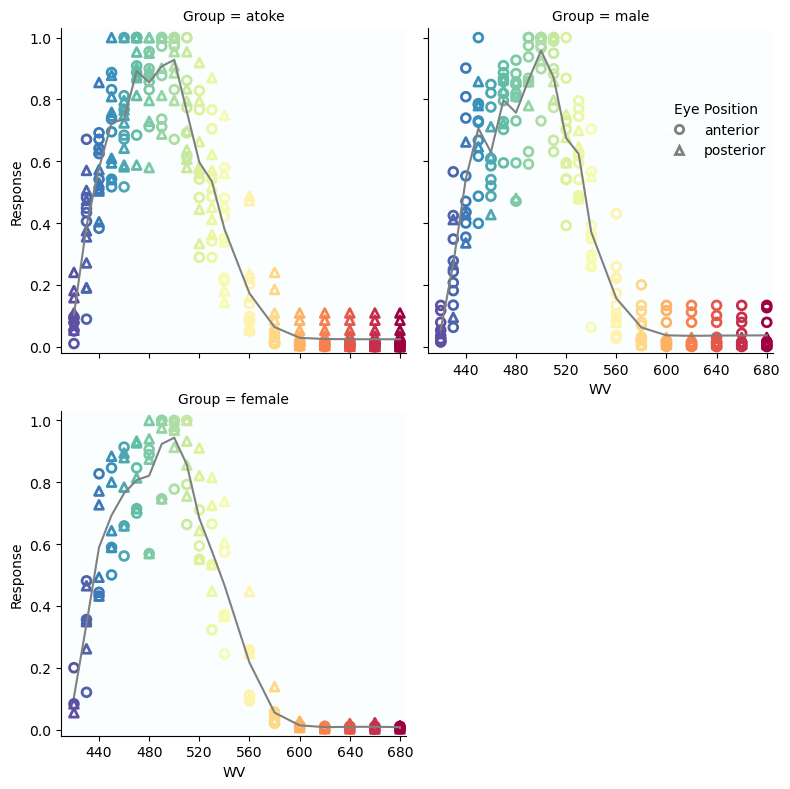

In [8]:
plt.figure(figsize=(6, 6))

g = sns.FacetGrid(spectral_df, col="Group", col_wrap=2, height=4)
g.map_dataframe(sns.lineplot, "WV", "Response", color='gray', errorbar=None)

# Define a dictionary to map EyePosition to marker styles
marker_map = {"anterior": "o", "posterior": "^"}

# Set facecolor for each axis
for ax in g.axes.flat:
    ax.set_facecolor('#FAFEFF')  # Extremely light blue, almost white

for i, group_name in enumerate(spectral_df['Group'].unique()):
    group = spectral_df[spectral_df['Group'] == group_name]
    valid_group = group.dropna(subset=["WV"])
    
    for eye_position, marker in marker_map.items():
        eye_group = valid_group[valid_group["EyePosition"] == eye_position]
        
        # Use the pre-generated colors for this group
        colors = all_colors[eye_group.index]
        
        g.axes.flat[i].scatter(eye_group["WV"], eye_group["Response"], 
                               facecolors='none', edgecolors=colors, s=40,
                               marker=marker, label=eye_position, linewidth=2)
        
        # Set axes limits
        ax.set(ylim=(-0.02, 1.03), xlim=(410, 685))

        # Set x-axis ticks
        ax.set_xticks(np.arange(440, 681, step=40))  

# Create a custom legend
legend_elements = [plt.Line2D([0], [0], marker=marker, color='w', label=eye_position,
                              markerfacecolor='none', markeredgecolor='gray', 
                              markersize=6, markeredgewidth=2)
                   for eye_position, marker in marker_map.items()]

# Add the legend to the figure
g.fig.legend(handles=legend_elements, title='Eye Position', loc='lower right',
             bbox_to_anchor=(0.98, 0.78), frameon=False)

plt.tight_layout()
#plt.savefig('spectral_sensitivity_by_group.pdf')
plt.show()

## Get least squares from opsin curve

In [9]:
av_spectral_df = spectral_df.groupby(['WV', 'Group']).agg({
    'Response': 'mean',
}).reset_index()

av_spectral_df.tail()

,WV,Group,Response
55,660,female,0.008957
56,660,male,0.036355
57,680,atoke,0.024050
58,680,female,0.007726
59,680,male,0.036670


In [10]:
# Load the data
df = pd.read_csv('../data/opsin_sensitivities.csv')
#df.drop(columns=['Pd_eyes'], inplace=True)
df.tail()

,WV,Pd_eyes,480,481,482,483,484,485,486,487,...,491,492,493,494,495,496,497,498,499,500
15,600,0.030739,0.003388,0.003776,0.004207,0.004684,0.005213,0.005797,0.006443,0.007157,...,0.010814,0.011965,0.013227,0.014609,0.016120,0.017770,0.019568,0.021525,0.023651,0.025958
16,620,0.027304,0.000603,0.000673,0.000751,0.000838,0.000934,0.001042,0.001161,0.001294,...,0.001992,0.002217,0.002466,0.002743,0.003049,0.003388,0.003763,0.004178,0.004636,0.005141
17,640,0.027678,0.000114,0.000128,0.000142,0.000158,0.000176,0.000196,0.000219,0.000243,...,0.000374,0.000416,0.000463,0.000515,0.000573,0.000637,0.000708,0.000788,0.000876,0.000973
18,660,0.027834,0.000024,0.000026,0.000029,0.000032,0.000036,0.000040,0.000044,0.000049,...,0.000075,0.000084,0.000093,0.000103,0.000114,0.000127,0.000141,0.000157,0.000174,0.000193
19,680,0.027610,0.000006,0.000007,0.000007,0.000008,0.000009,0.000010,0.000011,0.000012,...,0.000018,0.000020,0.000022,0.000025,0.000028,0.000030,0.000034,0.000037,0.000041,NaN


In [11]:
av_spectral_group_df = df.merge(av_spectral_df, left_on='WV', right_on='WV')
av_spectral_group_df.tail()

,WV,Pd_eyes,480,481,482,483,484,485,486,487,...,493,494,495,496,497,498,499,500,Group,Response
55,660,0.027834,0.000024,0.000026,0.000029,0.000032,0.000036,0.00004,0.000044,0.000049,...,0.000093,0.000103,0.000114,0.000127,0.000141,0.000157,0.000174,0.000193,female,0.008957
56,660,0.027834,0.000024,0.000026,0.000029,0.000032,0.000036,0.00004,0.000044,0.000049,...,0.000093,0.000103,0.000114,0.000127,0.000141,0.000157,0.000174,0.000193,male,0.036355
57,680,0.027610,0.000006,0.000007,0.000007,0.000008,0.000009,0.00001,0.000011,0.000012,...,0.000022,0.000025,0.000028,0.000030,0.000034,0.000037,0.000041,NaN,atoke,0.024050
58,680,0.027610,0.000006,0.000007,0.000007,0.000008,0.000009,0.00001,0.000011,0.000012,...,0.000022,0.000025,0.000028,0.000030,0.000034,0.000037,0.000041,NaN,female,0.007726
59,680,0.027610,0.000006,0.000007,0.000007,0.000008,0.000009,0.00001,0.000011,0.000012,...,0.000022,0.000025,0.000028,0.000030,0.000034,0.000037,0.000041,NaN,male,0.036670


In [12]:
# Define the function to calculate the least squares difference between two columns
def least_squares_diff(col1, col2):
    return sum((col1 - col2)**2)

# Function to find best match for a group
def find_best_match(group_df):
    ls_diffs = group_df.drop(columns=['WV', 'Pd_eyes', 'Group', 'Response', 'WV']).apply(
        lambda col: least_squares_diff(group_df['Response'], col), axis=0)
    return ls_diffs.idxmin()

# Group the dataframe by 'Group' and apply the find_best_match function
best_matches = av_spectral_group_df.groupby('Group').apply(find_best_match)

best_matches

C:\Users\seano\AppData\Local\Temp\ipykernel_14928\3605470636.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_matches = av_spectral_group_df.groupby('Group').apply(find_best_match)


Group
atoke     488
female    493
male      494
dtype: object

In [13]:
# Create the sequence of scaling factors
scaling_factors = np.arange(0.8, 1, 0.01)

# Column bind df['nm'] with df[best_matches]
result = pd.concat([df['WV'], df[best_matches]], axis=1).reset_index(drop=True)

# Create a dictionary mapping opsin to group
opsin_to_group = dict(zip(best_matches.values, best_matches.index))

# Pivot the result DataFrame
pivoted_result = result.melt(id_vars='WV', var_name='Opsin', value_name='Sensitivity')

# Add the group column based on the opsin
pivoted_result['Group'] = pivoted_result['Opsin'].map(opsin_to_group)

# Create a new DataFrame with all combinations of the original data and scaling factors
expanded_result = (pivoted_result.assign(key=1)
                   .merge(pd.DataFrame({'Scaling_factor': scaling_factors, 'key': 1}), on='key')
                   .drop('key', axis=1))

# Factor the sensitivity by the scaling factor
expanded_result['Scaled_sensitivity'] = expanded_result['Sensitivity'] * expanded_result['Scaling_factor']

# Reset the index
expanded_result = expanded_result.merge(av_spectral_df, on=['WV', 'Group'])
expanded_result = expanded_result.reset_index(drop=True)
expanded_result.tail()

,WV,Opsin,Sensitivity,Group,Scaling_factor,Scaled_sensitivity,Response
1195,680,494,0.000025,male,0.95,0.000024,0.03667
1196,680,494,0.000025,male,0.96,0.000024,0.03667
1197,680,494,0.000025,male,0.97,0.000024,0.03667
1198,680,494,0.000025,male,0.98,0.000024,0.03667
1199,680,494,0.000025,male,0.99,0.000025,0.03667


In [14]:
ls_diffs = pd.DataFrame(expanded_result.groupby(['Scaling_factor','Group']).apply(
        lambda x: least_squares_diff(x['Scaled_sensitivity'], x['Response'])
    )
).reset_index()
ls_diffs = ls_diffs.rename(columns={0: 'LS_diff'})

# Get the 'Scaling_factor' with the minimum 'LS_diff' for each 'Group'
best_scaling_factors = ls_diffs.groupby('Group').apply(lambda x: x.loc[x['LS_diff'].idxmin()])
best_scaling_factors = best_scaling_factors.reset_index(drop=True)

best_matches_df = pd.DataFrame(best_matches)
best_matches_df.rename(columns={0: 'Best_match'}, inplace=True)
best_matches_df = best_matches_df.merge(best_scaling_factors, on='Group')
best_matches_df

C:\Users\seano\AppData\Local\Temp\ipykernel_14928\2408637295.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ls_diffs = pd.DataFrame(expanded_result.groupby(['Scaling_factor','Group']).apply(
C:\Users\seano\AppData\Local\Temp\ipykernel_14928\2408637295.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_scaling_factors = ls_diffs.groupby('Group').apply(lambda x: x.loc[x['LS_diff'].idxmin()])


,Group,Best_match,Scaling_factor,LS_diff
0,atoke,488,0.91,0.080228
1,female,493,0.93,0.072982
2,male,494,0.89,0.122631


In [15]:
data = []

# For each row of best_matches 
for index, row in best_matches_df.iterrows():
    best_match = row['Best_match']
    scaling_factor = row['Scaling_factor']
    group = row['Group']
    
    # Calculate scaled sensitivity values
    sensitivity = df[best_match] * scaling_factor
    
    # Append data for each wavelength
    for wv, sens in zip(df['WV'], sensitivity):
        data.append({
            'WV': wv, 
            'Group': group, 
            'Sensitivity': sens,
            'Best_match': best_match,
            'Scaling_factor': scaling_factor
        })

# Create the new DataFrame
new_df = pd.DataFrame(data)

# Reset the index
new_df = new_df.merge(av_spectral_df, on=['WV', 'Group'])
new_df = new_df.reset_index(drop=True)
new_df.tail()

,WV,Group,Sensitivity,Best_match,Scaling_factor,Response
55,600,male,0.013002,494,0.89,0.036757
56,620,male,0.002441,494,0.89,0.035129
57,640,male,0.000458,494,0.89,0.035976
58,660,male,0.000092,494,0.89,0.036355
59,680,male,0.000022,494,0.89,0.036670


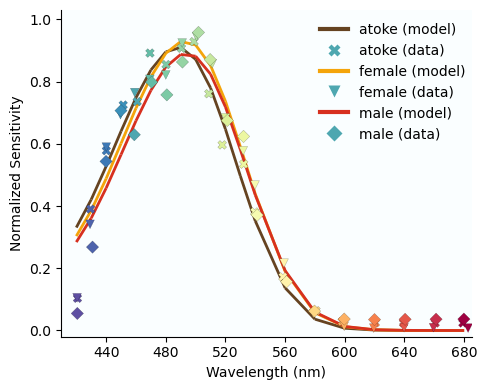

In [16]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.set_facecolor('#FAFEFF')  # Extremely light blue, almost white

marker_map = {"male": "D", "female": "v", "atoke": "X"}
linestyle_map = {"male": "dotted", "female": "dashed", "atoke": "solid"}
line_color_map = group_colors # {"male": "lightgray", "female": "gray", "atoke": "black"}

legend_elements = []
jitter_amount = 1  # Adjust this value to increase or decrease jitter

# Plot lines and scatter points for each group
for group in new_df['Group'].unique():
    group_data = new_df[new_df['Group'] == group]
    
    # Create line segments for LineCollection
    points = np.array([group_data['WV'], 
                       group_data['Sensitivity']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Generate colors for this group
    group_colors = generate_colormap(group_data['WV'])
    
    lc = LineCollection(segments, edgecolors='none', colors=line_color_map[group],
                        linewidth=2, zorder=1)  # linestyle=linestyle_map[group], 
    ax.add_collection(lc)

    # Add jitter to WV
    jittered_wv = group_data["WV"] + np.random.normal(0, jitter_amount, len(group_data["WV"]))
    
    scatter = ax.scatter(jittered_wv, group_data["Response"], 
                         c=group_colors, edgecolors='black', linewidth=0.1, s=40, 
                         marker=marker_map[group], zorder=2)

    # Create legend elements
    line = Line2D([0], [0], color=line_color_map[group], linewidth=3,   # linestyle=linestyle_map[group], 
                  label=f"{group} (model)")
    point = Line2D([0], [0], marker=marker_map[group], color='none', 
                   markerfacecolor=group_colors[4], markeredgecolor='none', 
                   markersize=8, label=f"{group} (data)")
    legend_elements.extend([line, point])

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Normalized Sensitivity')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set axes limits
ax.set(ylim=(-0.02, 1.03), xlim=(410, 685))

# Set x-axis ticks
ax.set_xticks(np.arange(440, 681, step=40))  

# Add legend
ax.legend(handles=legend_elements, frameon=False, loc='upper left', bbox_to_anchor=(0.6, 1))

plt.tight_layout()
#plt.savefig('spectral_sensitivity_fits.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()